In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as AdaBoost
import time
from __future__ import division

from sklearn.neighbors import KernelDensity as KDE

# Load and organize the data

In [2]:
# Load the data

# Inspections
insp = pd.read_csv('C:/Users/Joeseph/Dropbox/HGSE/CS109a Data Science/final project/data/Food_Inspections_Clean2.csv')
insp['date'] = pd.to_datetime(insp['Inspection Date'].astype('str'),infer_datetime_format=True)
insp.loc[:,'day_of_week']=insp.date.dt.dayofweek.values
insp.loc[:,'day_of_year']=insp.date.dt.dayofyear.values
insp.rename(columns={'License #':'license','Inspection ID':'ID','Facility Type':'facility','Inspection Type':'inspection_type'},
            inplace=True)
insp_all = insp.copy()
insp = insp[['ID','license','date','Results','Risk','facility','inspection_type',
             'month','day','year','day_of_week','day_of_year','Latitude','Longitude','Zip']]

# Weather
weath_big = pd.read_csv('C:/Users/Joeseph/Dropbox/HGSE/CS109a Data Science/final project/data/Weather_clean.csv',parse_dates=[6])
weath = weath_big[['date','tmax','tavg']]

# Complaints
comp_big = pd.read_csv('C:/Users/Joeseph/Dropbox/HGSE/CS109a Data Science/final project/data/311_clean.csv',parse_dates=[0,2])
#comp = comp_big[['created','nature','zip','longitude','latitude','ward','police district','community area']]
comp = comp_big[['created','nature','longitude','latitude']]

In [3]:
# Convert longitude,latitude pairs to x-y coordinates.
# I arbitrarily made a reference point (0,0) at -88,41.  This is slightly southwest of the city.
# Then, I converted long,lat coordinates to x,y in kilometers:

long_ref,lat_ref = -88,41
lat_to_km = 111.07
long_to_km = 83.00733

def longlat2xy(longitude,latitude):
    x = (longitude-long_ref)*long_to_km
    y = (latitude-lat_ref)*lat_to_km
    return x,y

# Convert the locations in inspections and complaints.
insp.loc[:,'x'],insp.loc[:,'y'] = longlat2xy(insp['Longitude'].values,insp['Latitude'].values)
comp.loc[:,'x'],comp.loc[:,'y'] = longlat2xy(comp['longitude'].values,comp['latitude'].values)

C:\Users\CORSAIR\Anaconda2\lib\site-packages\pandas\core\indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\CORSAIR\Anaconda2\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [4]:
insp.head(2)

,ID,license,date,Results,Risk,facility,inspection_type,month,day,year,day_of_week,day_of_year,Latitude,Longitude,Zip,x,y
0,1970470,1909713.0,2016-10-28,1.0,1.0,Restaurant,Short Form Complaint,10,28,2016,4,302,41.966063,-87.657734,60640.0,28.410576,107.300617
1,1970465,2215571.0,2016-10-28,0.0,1.0,Daycare Above and Under 2 Years,License,10,28,2016,4,302,41.759085,-87.567448,60649.0,35.904999,84.311624


In [5]:
comp.head(2)

,created,nature,longitude,latitude,x,y
0,2011-01-01,Garbage in alley,-87.712791,41.949330,23.840440,105.442125
1,2011-01-01,Garbage in yard,-87.708757,41.936356,24.175274,104.001023


In [6]:
weath.head(2)

,date,tmax,tavg
0,2010-01-01,16.0,NaN
1,2010-01-02,11.0,NaN


# Filter Inspections:

### Include only the following:
* Results exist (already done in the cleaning)
* Inspection type is 
    * Canvass
    * Complaint
    * Short Form Complaint
    * Suspected Food Poisoning
* Facility type is
    * Restaurant
    * Grocery Store
    * Bakery
* License exists
* Location exists

In [7]:
n_all = insp.shape[0]
print 'number of records with inspection results: {:,}'.format(n_all)

number of records with inspection results: 118,102


In [8]:
# Filter inspection types
print "Most common Inspection types in the raw data:"
print insp.inspection_type.value_counts(dropna=False).head(10)

insp = insp.query('inspection_type in ["Canvass","Complaint","Short Form Complaint","Suspected Food Poisoning"]')
print "\n\n\nInspection types after filtering:"
print insp.inspection_type.value_counts(dropna=False).head(10)


Most common Inspection types in the raw data:
Canvass                     55858
License                     16811
Canvass Re-Inspection       12686
Complaint                   11912
License Re-Inspection        6601
Short Form Complaint         5271
Complaint Re-Inspection      5018
Suspected Food Poisoning      646
Consultation                  635
Tag Removal                   603
Name: inspection_type, dtype: int64



Inspection types after filtering:
Canvass                     55858
Complaint                   11912
Short Form Complaint         5271
Suspected Food Poisoning      646
Name: inspection_type, dtype: int64


In [9]:
# Filter facility types
print "Most common Facility types in the raw data:"
print insp.facility.value_counts(dropna=False).head(10)

insp = insp.query('facility in ["Restaurant","Grocery Store","Bakery"]')
print "\n\n\nFacility types after filtering:"
print insp.facility.value_counts(dropna=False).head(10)


Most common Facility types in the raw data:
Restaurant                         51953
Grocery Store                       8846
School                              6499
Bakery                              1071
Daycare (2 - 6 Years)                615
Long Term Care                       499
Daycare Above and Under 2 Years      452
Catering                             396
Children's Services Facility         337
Golden Diner                         283
Name: facility, dtype: int64



Facility types after filtering:
Restaurant       51953
Grocery Store     8846
Bakery            1071
Name: facility, dtype: int64


In [10]:
# Drop records with no license.
insp = insp[insp.license.notnull()]

In [11]:
# Drop records with no location.
insp = insp[insp.Latitude.notnull()]

In [12]:
n_rem = insp.shape[0]
print 'After filtering, there are {:,} records remaining ({}%)'.format(n_rem,round(100.*n_rem/n_all,2))

After filtering, there are 61,727 records remaining (52.27%)


## predictors from individual establishment

In [13]:
%%time

tstart = time.time()
agg = np.empty((insp.shape[0],4))
for i,(idx,r) in enumerate(insp.iterrows()):
    lic = r.license
    date = r.date
    prev_insps = insp[(insp.license==lic) & (insp.date<date)]
    prev = prev_insps.nlargest(1,'date')
    mean_result = prev_insps.Results.mean()
    if len(prev)>0:
        dt = (date-prev.date).dt.days.values
        agg[i] = [idx,dt,prev.Results,mean_result]
    else:
        agg[i] = [idx,np.nan,np.nan,np.nan]
    if (i+1)%10000==0:
        print 'i={:,}, t={}'.format(i+1,time.time()-tstart)
    

i=10,000, t=31.7799999714
i=20,000, t=63.4600000381
i=30,000, t=95.0720000267
i=40,000, t=129.264999866
i=50,000, t=162.914999962
i=60,000, t=193.861999989
Wall time: 3min 17s


In [14]:
ind_pred = pd.DataFrame(agg[:,1:],index=agg[:,0],columns=['days_since_insp','last_insp_result','mean_insp_result'])
ind_pred.head(5)

,days_since_insp,last_insp_result,mean_insp_result
0.0,121.0,2.0,1.70
4.0,120.0,0.0,0.25
5.0,231.0,0.0,0.00
7.0,343.0,0.0,0.75
11.0,140.0,1.0,0.25


In [15]:
insp = pd.concat((insp,ind_pred),axis=1)

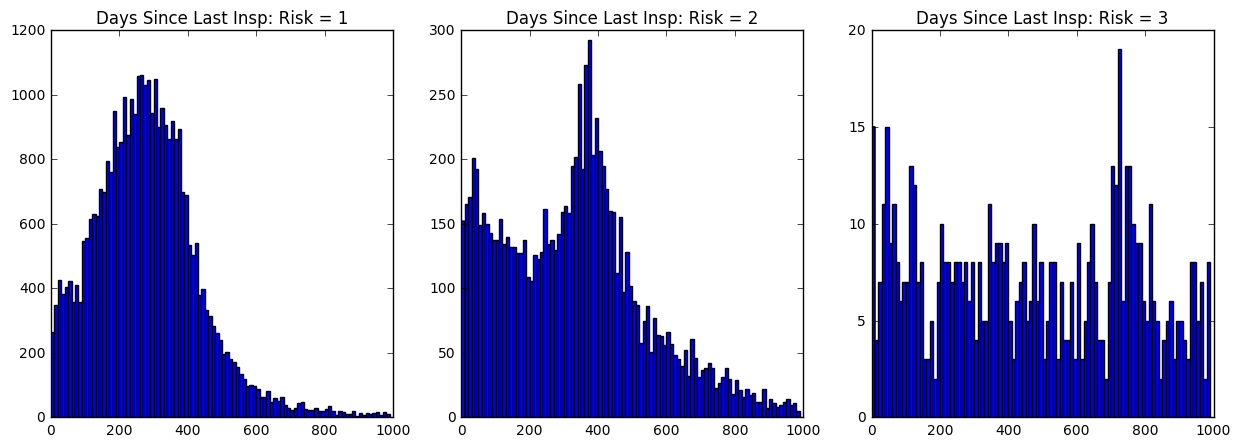

In [16]:
plt.figure(figsize=(15,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    v = insp.ix[insp.Risk==i,'days_since_insp']
    plt.hist(v[v.notnull()].values,bins=np.arange(0,1000,10))
    plt.title('Days Since Last Insp: Risk = {}'.format(i))

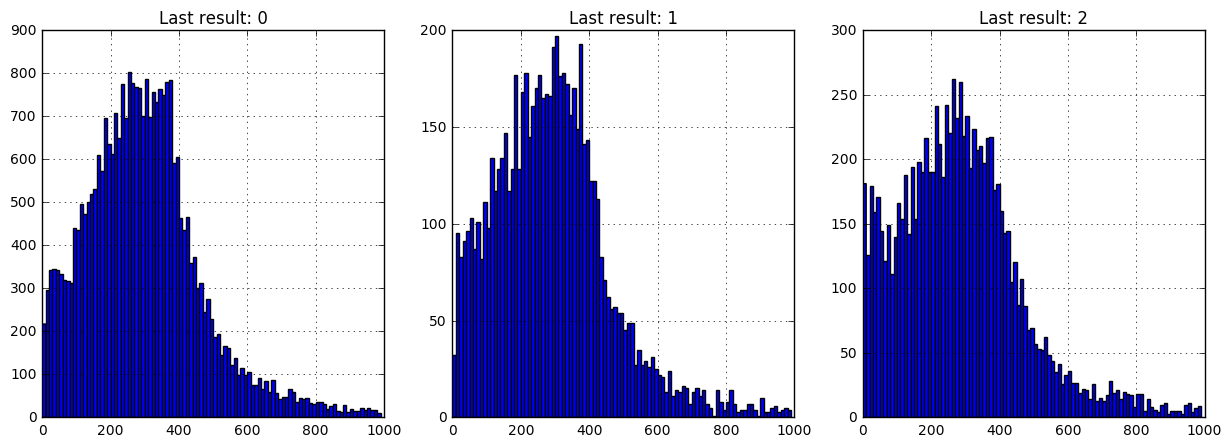

In [17]:
plt.figure(figsize=(15,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    v = insp.ix[insp.last_insp_result==i-1,'days_since_insp']
    plt.hist(v[v.notnull()].values,bins=np.arange(0,1000,10))
    plt.title('Last result: {}'.format(i-1))
    plt.grid('on')

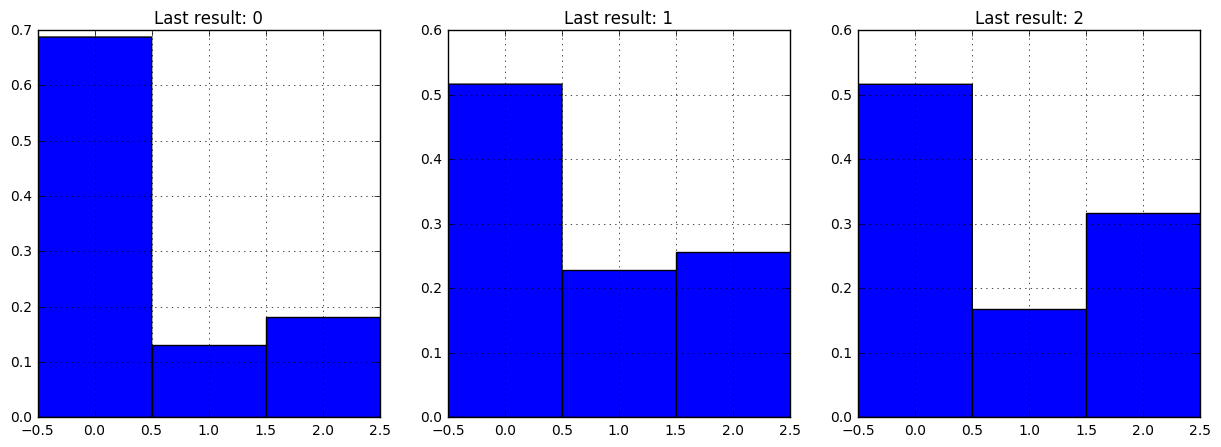

In [18]:
plt.figure(figsize=(15,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    v = insp.ix[insp.last_insp_result==i-1,'Results']
    plt.hist(v[v.notnull()].values,bins=np.arange(0,4)-0.5,normed=True)
    plt.title('Last result: {}'.format(i-1))
    plt.grid('on')

In [19]:
insp.isnull().mean()

ID                  0.000000
license             0.000000
date                0.000000
Results             0.000000
Risk                0.000000
facility            0.000000
inspection_type     0.000000
month               0.000000
day                 0.000000
year                0.000000
day_of_week         0.000000
day_of_year         0.000000
Latitude            0.000000
Longitude           0.000000
Zip                 0.000243
x                   0.000000
y                   0.000000
days_since_insp     0.239863
last_insp_result    0.239863
mean_insp_result    0.239863
dtype: float64

(array([ 2296.,  2342.,  1733.,   927.,   776.,   675.,   480.,   500.,
          501.,   475.,   512.,   481.,   460.,   491.,   429.,   262.,
          372.,   431.,   414.,   249.]),
 array([ 733776. ,  733900.3,  734024.6,  734148.9,  734273.2,  734397.5,
         734521.8,  734646.1,  734770.4,  734894.7,  735019. ,  735143.3,
         735267.6,  735391.9,  735516.2,  735640.5,  735764.8,  735889.1,
         736013.4,  736137.7,  736262. ]),
 <a list of 20 Patch objects>)

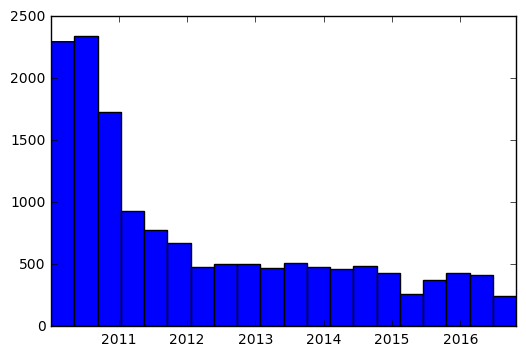

In [20]:
# This is justification to throw away the results from the first year.  Start in 2011.
plt.hist(insp[insp.mean_insp_result.isnull()].date.values,bins=20)

In [21]:
# Fill in the missing values and make a missing predictor.
insp['first_insp']=1*insp['mean_insp_result'].isnull()
insp.ix[insp.mean_insp_result.isnull(),['mean_insp_result','days_since_insp','last_insp_result']]=-1


In [22]:
insp.isnull().mean()

ID                  0.000000
license             0.000000
date                0.000000
Results             0.000000
Risk                0.000000
facility            0.000000
inspection_type     0.000000
month               0.000000
day                 0.000000
year                0.000000
day_of_week         0.000000
day_of_year         0.000000
Latitude            0.000000
Longitude           0.000000
Zip                 0.000243
x                   0.000000
y                   0.000000
days_since_insp     0.000000
last_insp_result    0.000000
mean_insp_result    0.000000
first_insp          0.000000
dtype: float64

# Get predictors for 3-day high temp

In [23]:
weath = weath_big[['date','tmax','tavg']]

In [24]:
# Make 1-week rolling average column
# Fill in the missing daily highs (the last 2 days) with the existing daily averages.
weath.ix[2494:2495,'tmax'] = weath.ix[2494:2495,'tavg']
weath = weath.drop('tavg',axis=1)

weath.ix[:,'tavg_3day']=weath['tmax'].rolling(window=3,min_periods=1).mean()
weath.head(10)

,date,tmax,tavg_3day
0,2010-01-01,16.0,16.000000
1,2010-01-02,11.0,13.500000
2,2010-01-03,18.0,15.000000
3,2010-01-04,18.0,15.666667
4,2010-01-05,23.0,19.666667
5,2010-01-06,20.0,20.333333
6,2010-01-07,22.0,21.666667
7,2010-01-08,27.0,23.000000
8,2010-01-09,22.0,23.666667
9,2010-01-10,18.0,22.333333


In [25]:
weath.isnull().sum()

date         0
tmax         0
tavg_3day    0
dtype: int64

In [26]:
# add weather information to the inspection table
insp = pd.merge(insp,weath[['date','tmax','tavg_3day']],how='left',on='date').set_index(insp.index)

# Risk, Facility Types, and Inspection Types

In [27]:
it_dummies = pd.get_dummies(insp.inspection_type,prefix='it').drop('it_Canvass',axis=1)
ft_dummies = pd.get_dummies(insp.facility,prefix='ft').drop('ft_Restaurant',axis=1)
risk_dummies = pd.get_dummies(insp.Risk,prefix='risk').drop('risk_1.0',axis=1)


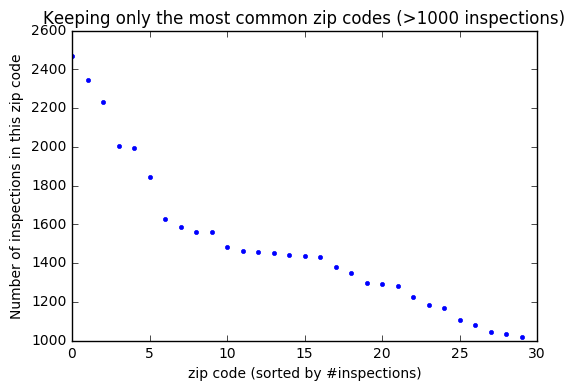

In [28]:
# I'm making a new filed, zip2, in which all the rare zips are replaced by nans.
insp.loc[:,'zip2'] = insp.Zip.copy()
smallzip_idx = insp.zip2.value_counts()<1000
smallzips = smallzip_idx.index[smallzip_idx]
insp.ix[insp.zip2.isin(smallzips),'zip2']=np.nan

v = insp.zip2.value_counts(normalize=False)
plt.plot(v.values,'.')
plt.ylabel('Number of inspections in this zip code')
plt.xlabel('zip code (sorted by #inspections)')
plt.title('Keeping only the most common zip codes (>1000 inspections)')

In [29]:
zip_dummies = pd.get_dummies(insp.zip2)

# KDE setup

In [30]:
train = insp.ix[:2000,['x','y','Results']]
test = insp.ix[2000:4000,['x','y','Results']]

In [31]:
def KDE_inspection_outcome(train,test):
    #localization parameter
    loc = 2e0 
    # get baseline rates
    br = train.Results.value_counts(normalize=True)
    
    # set up the models for the 
    # passed tests, provisional fails, and critical fails
    kde_pass = KDE(bandwidth=loc)
    kde_pfail = KDE(bandwidth=loc)
    kde_cfail = KDE(bandwidth=loc)
    
    # fit the models
    kde_pass.fit(train.ix[train['Results']==0,['x','y']].values)
    kde_pfail.fit(train.ix[train['Results']==1,['x','y']].values)
    kde_cfail.fit(train.ix[train['Results']==2,['x','y']].values)
    
    # get densities on the testing data
    Xtest = test[['x','y']].values
    k_pass  = np.exp( kde_pass.score_samples(Xtest))*br[0]
    k_pfail = np.exp(kde_pfail.score_samples(Xtest))*br[1]
    k_cfail = np.exp(kde_cfail.score_samples(Xtest))*br[2]
    
    # Get probabilities of pass, pfail, and cfail at all test points
    p_pass  = k_pass /(k_pass+k_pfail+k_cfail)
    p_pfail = k_pfail/(k_pass+k_pfail+k_cfail)
    p_cfail = k_cfail/(k_pass+k_pfail+k_cfail)
    
    return (np.concatenate((p_pass,p_pfail,p_cfail)).reshape(3,-1).T,
            np.concatenate((k_pass,k_pfail,k_cfail)).reshape(3,-1).T)
    #return pd.DataFrame({'p_pass':p_pass,'p_pfail':p_pfail,'p_cfail':p_cfail},index=test.index)


In [32]:
(df,_) = KDE_inspection_outcome(train,test)

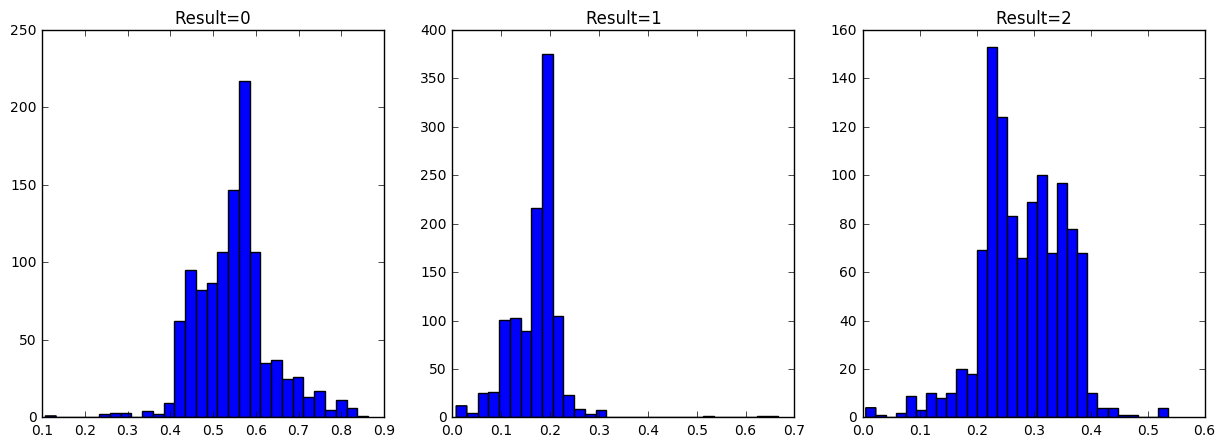

In [33]:
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist(df[:,i],bins=30)
    plt.title('Result={}'.format(i))

In [34]:
def plot_insp_KDE_pred(test,KDE_result,cmap=plt.get_cmap('RdYlGn_r'),title=None):
    plt.figure(figsize=(6,4))
    plt.scatter(test.x.values,test.y.values,c=KDE_result,cmap=cmap,s=60,vmin=0,vmax=1)
    if title:
        plt.title(title)
    plt.colorbar()


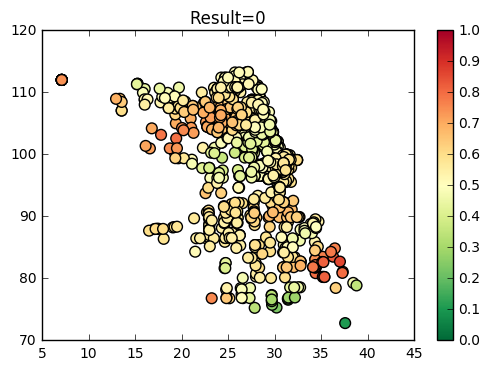

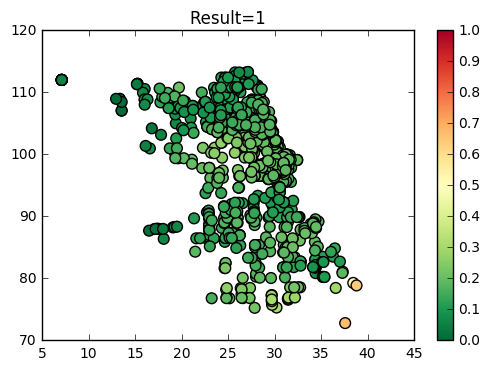

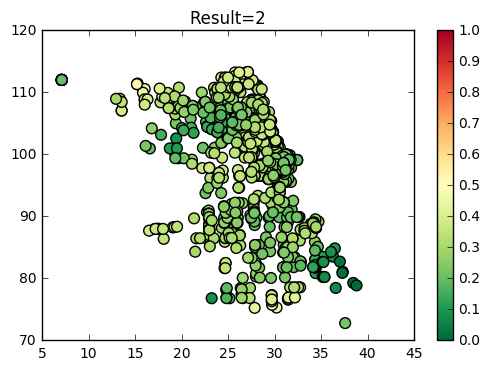

In [35]:
plot_insp_KDE_pred(test,df[:,0],plt.get_cmap('RdYlGn_r'),'Result=0')
plot_insp_KDE_pred(test,df[:,1],plt.get_cmap('RdYlGn_r'),'Result=1')
plot_insp_KDE_pred(test,df[:,2],plt.get_cmap('RdYlGn_r'),'Result=2')

In [36]:
xlocs = np.arange(5,45,1)
ylocs = np.arange(60,120,1)
xgrid,ygrid = np.meshgrid(xlocs,ylocs)
xylocs = pd.DataFrame(np.concatenate((xgrid.reshape(-1,1),ygrid.reshape(-1,1)),axis=1),columns=['x','y'])
(_,grid_predictions) = KDE_inspection_outcome(train,xylocs)

In [37]:
def plot_heatmap_probability(xgrid,ygrid,grid_pred,testlocs,idx_plotted=2,cmap=plt.get_cmap('RdYlGn_r'),title=None):
    p = grid_pred[:,idx_plotted]/grid_pred.sum(axis=1)
    plt.contourf(xgrid,ygrid,p.reshape(xgrid.shape),cmap=cmap,vmin=0,vmax=1)
    if title:
        plt.title(title)
    plt.colorbar()
    plt.grid('on')
    plt.scatter(testlocs.x,testlocs.y,color='k',s=5)

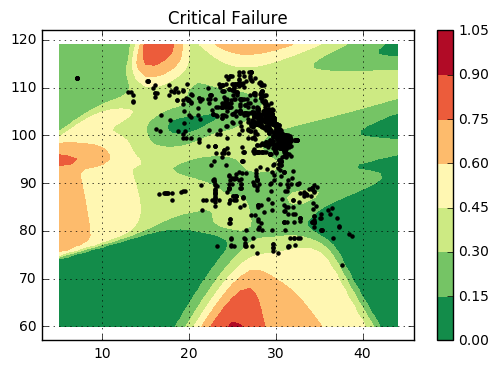

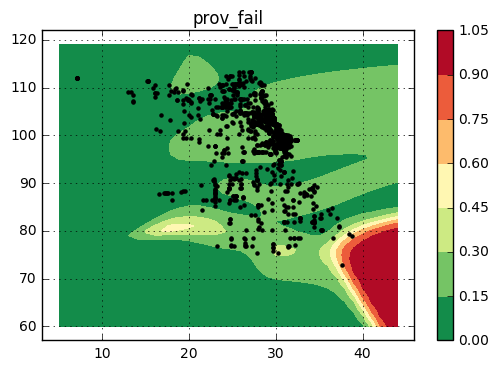

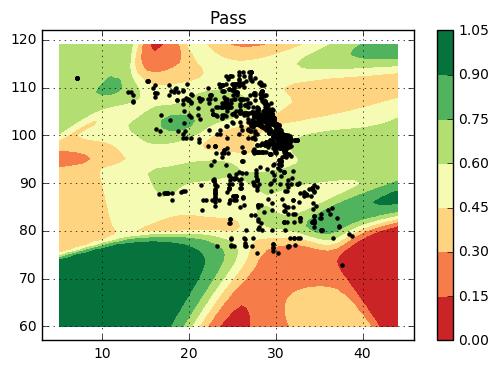

In [38]:
plot_heatmap_probability(xgrid,ygrid,grid_predictions,test,idx_plotted=2,title='Critical Failure')
plt.show()
plot_heatmap_probability(xgrid,ygrid,grid_predictions,test,idx_plotted=1,title='prov_fail')
plt.show()
plot_heatmap_probability(xgrid,ygrid,grid_predictions,test,idx_plotted=0,title='Pass',cmap=plt.get_cmap('RdYlGn'))

In [39]:
def plot_heatmap_density(xgrid,ygrid,grid_pred,testlocs,idx_plotted=2,cmap=plt.get_cmap('viridis'),title=None):
    p = grid_pred[:,idx_plotted]
    plt.contourf(xgrid,ygrid,p.reshape(xgrid.shape),cmap=cmap)
    if title:
        plt.title(title)
    plt.colorbar()
    plt.grid('on')
    plt.scatter(testlocs.x,testlocs.y,color='w',s=2)

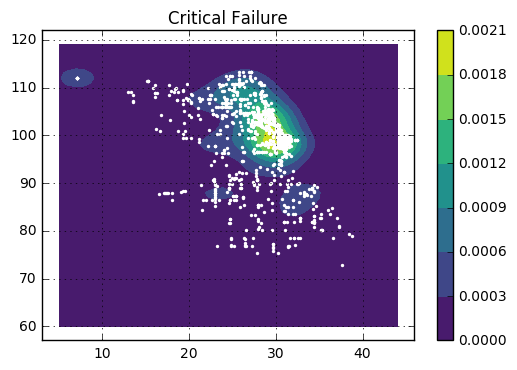

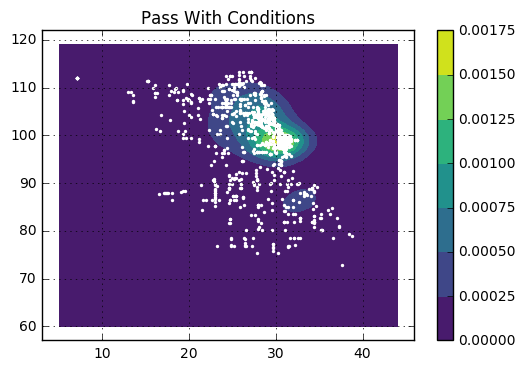

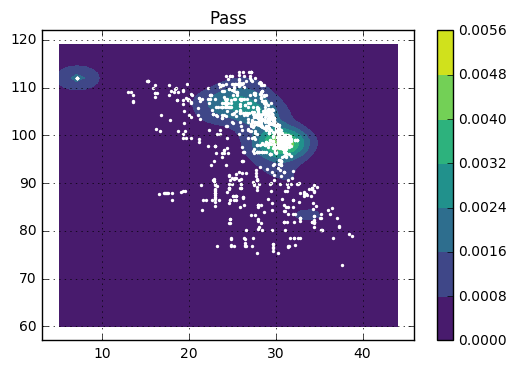

In [40]:
plot_heatmap_density(xgrid,ygrid,grid_predictions,test,idx_plotted=2,title='Critical Failure')
plt.show()
plot_heatmap_density(xgrid,ygrid,grid_predictions,test,idx_plotted=1,title='Pass With Conditions')
plt.show()
plot_heatmap_density(xgrid,ygrid,grid_predictions,test,idx_plotted=0,title='Pass')

# Define the loss function

In [41]:
# For Ytrue (integers specifying class) and Ypred (n x m array of probabilities),
# calculate the negative log loss (i.e. neg log likelihood)

# Return the tuple (average neg log loss, characteristic probability)
def log_loss(Ytrue,Ypred):
    badidx = np.isnan(Ytrue)
    Ytrue = Ytrue[~badidx]
    Ypred = Ypred[~badidx,:]
    n,m = Ypred.shape
    
    if not np.issubdtype(Ytrue.dtype,np.integer):
        Ytrue = Ytrue.copy().astype('int')
    
    # p is the predicted probability of the event that happened
    p = Ypred[np.arange(n),Ytrue]
    # A hack to avoid being certain something will never happen
    # This sets the minimum value to 0.01
    x = 0.01031
    p = (p+x)/(1+3*x)
    
    ave_loss = -np.log(p).mean()
    char_p = np.exp(-ave_loss)
    return ave_loss,char_p

# Make some models!

In [42]:
# cut the first year.
insp_final = insp[insp.date>pd.datetime(2011,1,1)]
retidx = insp.date>pd.datetime(2011,1,1)
zip_dummies[retidx].shape

(53842, 30)

# Restaurant's history

In [43]:
insp_final.columns

Index([u'ID', u'license', u'date', u'Results', u'Risk', u'facility',
       u'inspection_type', u'month', u'day', u'year', u'day_of_week',
       u'day_of_year', u'Latitude', u'Longitude', u'Zip', u'x', u'y',
       u'days_since_insp', u'last_insp_result', u'mean_insp_result',
       u'first_insp', u'tmax', u'tavg_3day', u'zip2'],
      dtype='object')

In [44]:
# Get the outcomes of the inspections;
# Delete the rows with missing outcomes.
Yall = insp_final.Results.values
badidx = np.isnan(Yall)
Y = Yall[~badidx]

In [45]:
# Make logistic models adding factors to the dow-year-zip (time-place models)

# Do 10-fold CV to estimate generalization ability of the models.

n = Y.shape[0]
n_folds = 10
kf = TimeSeriesSplit(n_splits=n_folds)

model_names = ['baseline','zip+insp_type+fac_type+risk','+t_since_insp','+prev_result',
               '+prev_result+mean_prev_result','+t_since_insp+prev_result+mean_prev_result']
n_models = len(model_names)

# Define the predictors for each model
X1 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx]),axis=1).values
X0 = (X1[:,0]*0+1).reshape(-1,1)
X2 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.days_since_insp),axis=1).values
X3 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2),axis=1).values
X4 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result),axis=1).values
X5 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result,insp_final.days_since_insp),axis=1).values

# Aggregate the predictors for all the models
allX = []
for i in range(n_models):
    allX.append(eval('X{}'.format(i)))

# Loop through the k-folds
mll = np.empty((n_folds,n_models))
charp = np.empty_like(mll)
for i,(ktrain,ktest) in enumerate(kf.split(Y)):
    
    for j in range(n_models):
        mdl = LogReg(C=1000).fit(allX[j][ktrain,:],Y[ktrain])
        Yproba = mdl.predict_proba(allX[j][ktest,:])
        mll[i,j],charp[i,j] = log_loss(Y[ktest],Yproba)

In [46]:
# Also fit the entire data to get in-sample fits
mll_insample = np.empty(n_models)
charp_insample = np.empty_like(mll_insample)
for j in range(n_models):
    mdl = LogReg(C=1000).fit(allX[j],Y)
    Yproba = mdl.predict_proba(allX[j])
    mll_insample[j],charp_insample[j] = log_loss(Y,Yproba)

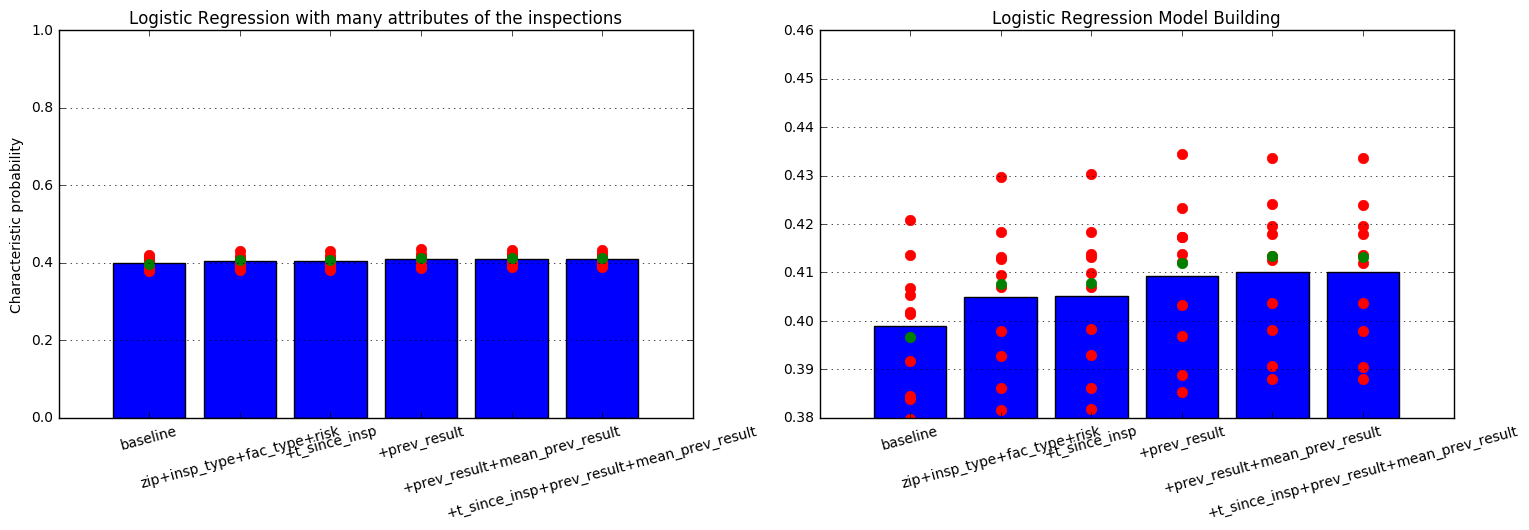

In [47]:
# Plot the characteristic probability for each of the models
plt.figure(figsize=(18,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    mnp = charp.mean(axis=0)
    plt.bar(np.arange(n_models),mnp,align="center")
    mgx,_ = np.meshgrid(range(n_models),range(n_folds))
    plt.plot(mgx,charp,'r.',markersize=15)
    plt.plot(mgx[0,:],charp_insample,'g.',markersize=15)
    plt.xticks(mgx[0,:],model_names,rotation=15)
    plt.ylim([0,1])
    plt.grid(axis='y')
    plt.title('Logistic Regression with many attributes of the inspections')
    if i==1:
        plt.ylim([0.38,0.46])
        plt.title('Logistic Regression Model Building')
    else:
        plt.ylabel('Characteristic probability')
plt.show()

In [48]:
pd.DataFrame(mdl.coef_)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.511964,0.237901,0.322942,-0.189060,0.109482,0.430299,-0.506565,-0.030564,0.142190,-0.517662,...,-0.808150,0.053680,-0.188322,0.076643,0.399504,-1.053541,-0.409363,-0.207522,-0.452321,-0.000158
1,-0.059022,0.070875,0.216043,0.219882,-0.182187,-0.265742,0.741955,0.260893,0.160859,0.620528,...,0.629934,-0.462059,0.087323,-0.037649,-1.226951,0.782782,0.456930,-0.008669,0.237638,0.000126
2,-0.794264,-0.471681,-0.747014,0.045628,-0.070275,-0.458377,-0.025050,-0.202495,-0.357949,0.081947,...,0.344542,0.226380,0.176083,-0.079516,0.170879,0.789101,0.176625,0.240957,0.414845,0.000043


C:\Users\CORSAIR\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


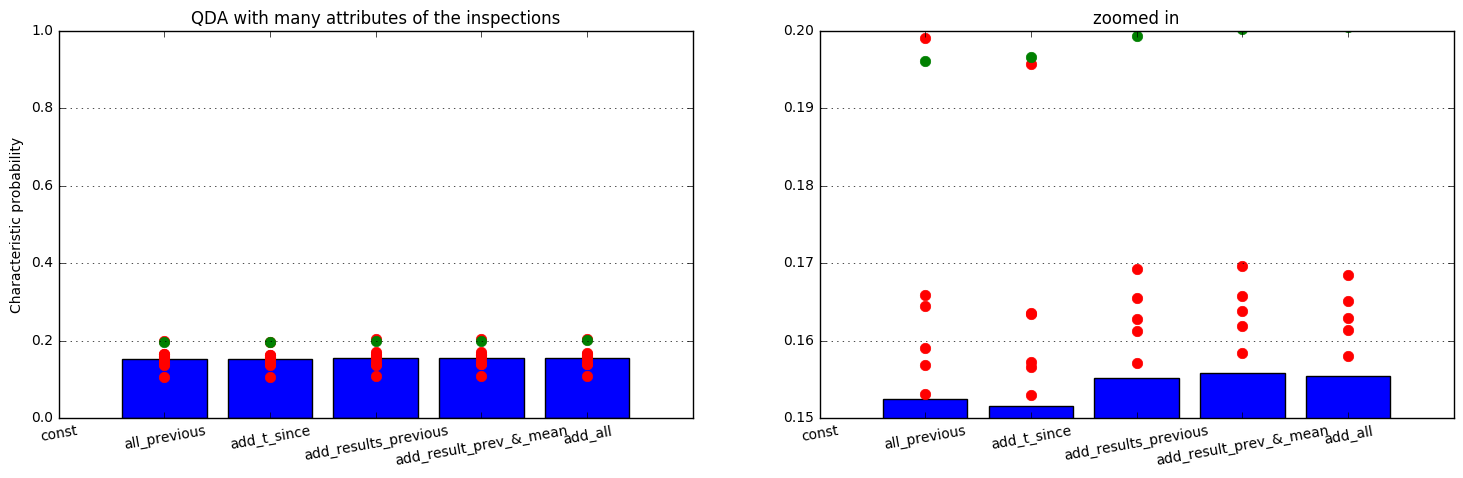

In [49]:
# Make QDA models with 10-fold CV and plotting.

n = Y.shape[0]
n_folds = 10
kf = TimeSeriesSplit(n_splits=n_folds)

model_names = ['const','all_previous','add_t_since','add_results_previous','add_result_prev_&_mean','add_all']
n_models = len(model_names)

# Define the predictors for each model
X1 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx]),axis=1).values
X0 = (X1[:,0]*0+1).reshape(-1,1)
X2 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.days_since_insp),axis=1).values
X3 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2),axis=1).values
X4 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result),axis=1).values
X5 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result,insp_final.days_since_insp),axis=1).values

# Aggregate the predictors for all the models
allX = []
for i in range(n_models):
    allX.append(eval('X{}'.format(i)))

# Loop through the k-folds
mll = np.empty((n_folds,n_models))
charp = np.empty_like(mll)
for i,(ktrain,ktest) in enumerate(kf.split(Y)):
    
    for j in range(n_models):
        mdl = QDA().fit(allX[j][ktrain,:],Y[ktrain])
        Yproba = mdl.predict_proba(allX[j][ktest,:])
        mll[i,j],charp[i,j] = log_loss(Y[ktest],Yproba)
        
# Also fit the entire data to get in-sample fits
mll_insample = np.empty(n_models)
charp_insample = np.empty_like(mll_insample)
for j in range(n_models):
    mdl = QDA().fit(allX[j],Y)
    Yproba = mdl.predict_proba(allX[j])
    mll_insample[j],charp_insample[j] = log_loss(Y,Yproba)
    
# Plot the characteristic probability for each of the models
plt.figure(figsize=(18,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    mnp = charp.mean(axis=0)
    plt.bar(np.arange(n_models),mnp,align="center")
    mgx,_ = np.meshgrid(range(n_models),range(n_folds))
    plt.plot(mgx,charp,'r.',markersize=15)
    plt.plot(mgx[0,:],charp_insample,'g.',markersize=15)
    plt.xticks(mgx[0,:],model_names,rotation=10)
    plt.ylim([0,1])
    plt.grid(axis='y')
    plt.title('QDA with many attributes of the inspections')
    if i==1:
        plt.ylim([0.15,0.20])
        plt.title('zoomed in')
    else:
        plt.ylabel('Characteristic probability')
plt.show()

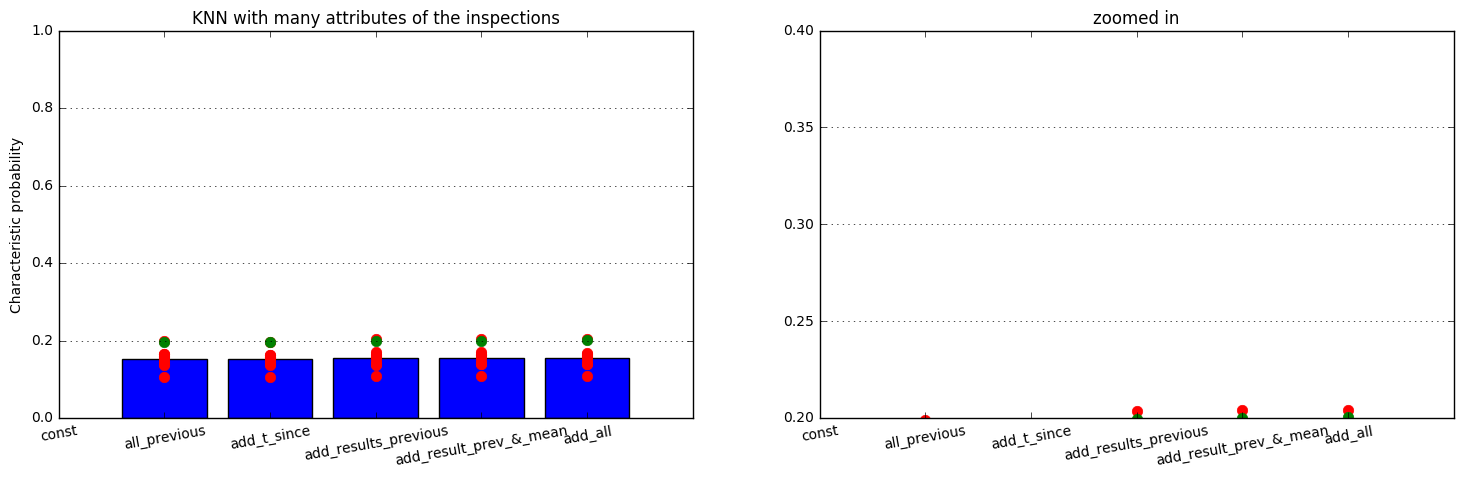

In [50]:
# Plot the characteristic probability for each of the models
plt.figure(figsize=(18,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    mnp = charp.mean(axis=0)
    plt.bar(np.arange(n_models),mnp,align="center")
    mgx,_ = np.meshgrid(range(n_models),range(n_folds))
    plt.plot(mgx,charp,'r.',markersize=15)
    plt.plot(mgx[0,:],charp_insample,'g.',markersize=15)
    plt.xticks(mgx[0,:],model_names,rotation=10)
    plt.ylim([0,1])
    plt.grid(axis='y')
    plt.title('KNN with many attributes of the inspections')
    if i==1:
        plt.ylim([0.2,0.4])
        plt.title('zoomed in')
    else:
        plt.ylabel('Characteristic probability')
plt.show()

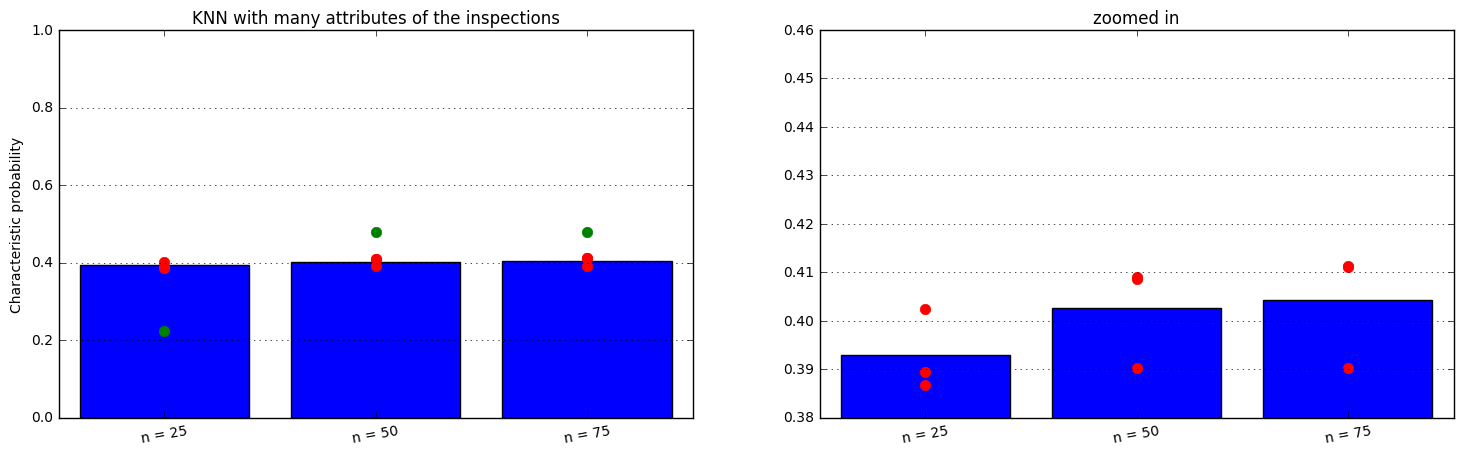

In [51]:
# try some different n-neighbors values

n = Y.shape[0]
n_folds = 3
kf = TimeSeriesSplit(n_splits=n_folds)

n_neighbors = [25, 50, 75]
model_names = ['n = 25','n = 50','n = 75']
n_models = len(model_names)

# Define the predictors for each model
X1 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result,insp_final.days_since_insp),axis=1).values
X2 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result,insp_final.days_since_insp),axis=1).values
X3 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result,insp_final.days_since_insp),axis=1).values

# Aggregate the predictors for all the models
allX = []
for i in range(n_models):
    allX.append(eval('X{}'.format(i)))

# Loop through the k-folds
mll = np.empty((n_folds,n_models))
charp = np.empty_like(mll)
for i,(ktrain,ktest) in enumerate(kf.split(Y)):
    
    for j in range(n_models):
        mdl = KNN(n_neighbors = n_neighbors[j]).fit(allX[j][ktrain,:],Y[ktrain])
        Yproba = mdl.predict_proba(allX[j][ktest,:])
        mll[i,j],charp[i,j] = log_loss(Y[ktest],Yproba)
        
# Also fit the entire data to get in-sample fits
mll_insample = np.empty(n_models)
charp_insample = np.empty_like(mll_insample)
for j in range(n_models):
    mdl = KNN().fit(allX[j],Y)
    Yproba = mdl.predict_proba(allX[j])
    mll_insample[j],charp_insample[j] = log_loss(Y,Yproba)
    
# Plot the characteristic probability for each of the models
plt.figure(figsize=(18,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    mnp = charp.mean(axis=0)
    plt.bar(np.arange(n_models),mnp,align="center")
    mgx,_ = np.meshgrid(range(n_models),range(n_folds))
    plt.plot(mgx,charp,'r.',markersize=15)
    plt.plot(mgx[0,:],charp_insample,'g.',markersize=15)
    plt.xticks(mgx[0,:],model_names,rotation=10)
    plt.ylim([0,1])
    plt.grid(axis='y')
    plt.title('KNN with many attributes of the inspections')
    if i==1:
        plt.ylim([0.38,0.46])
        plt.title('zoomed in')
    else:
        plt.ylabel('Characteristic probability')
plt.show()

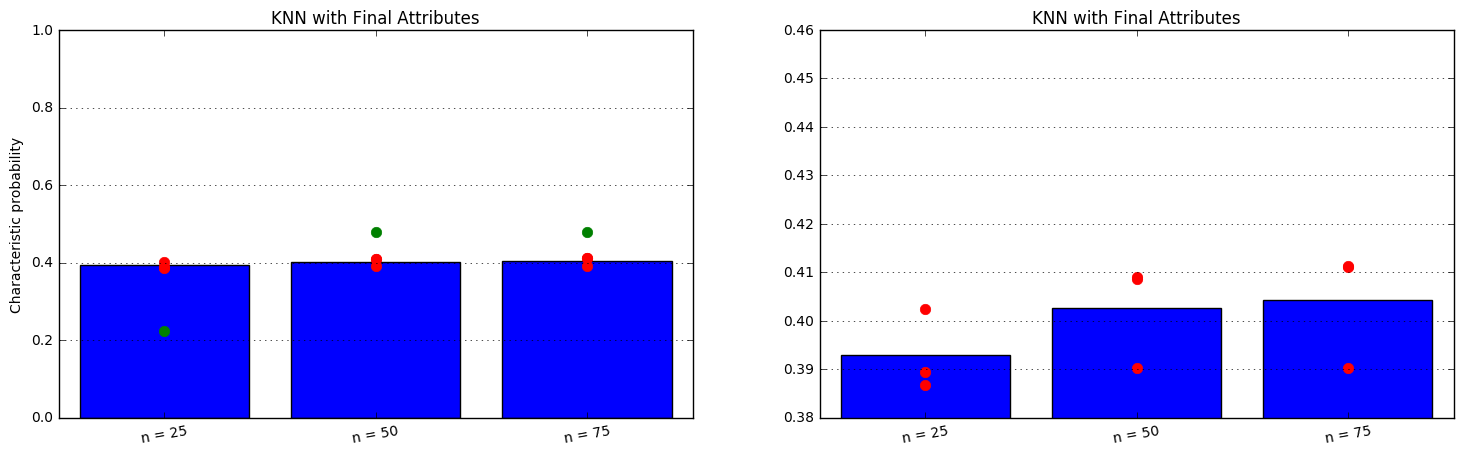

In [52]:
# Plot the characteristic probability for each of the models
plt.figure(figsize=(18,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    mnp = charp.mean(axis=0)
    plt.bar(np.arange(n_models),mnp,align="center")
    mgx,_ = np.meshgrid(range(n_models),range(n_folds))
    plt.plot(mgx,charp,'r.',markersize=15)
    plt.plot(mgx[0,:],charp_insample,'g.',markersize=15)
    plt.xticks(mgx[0,:],model_names,rotation=10)
    plt.ylim([0,1])
    plt.grid(axis='y')
    plt.title('KNN with Final Attributes')
    if i==1:
        plt.ylim([0.38,0.46])
        plt.title('KNN with Final Attributes')
    else:
        plt.ylabel('Characteristic probability')
plt.show()

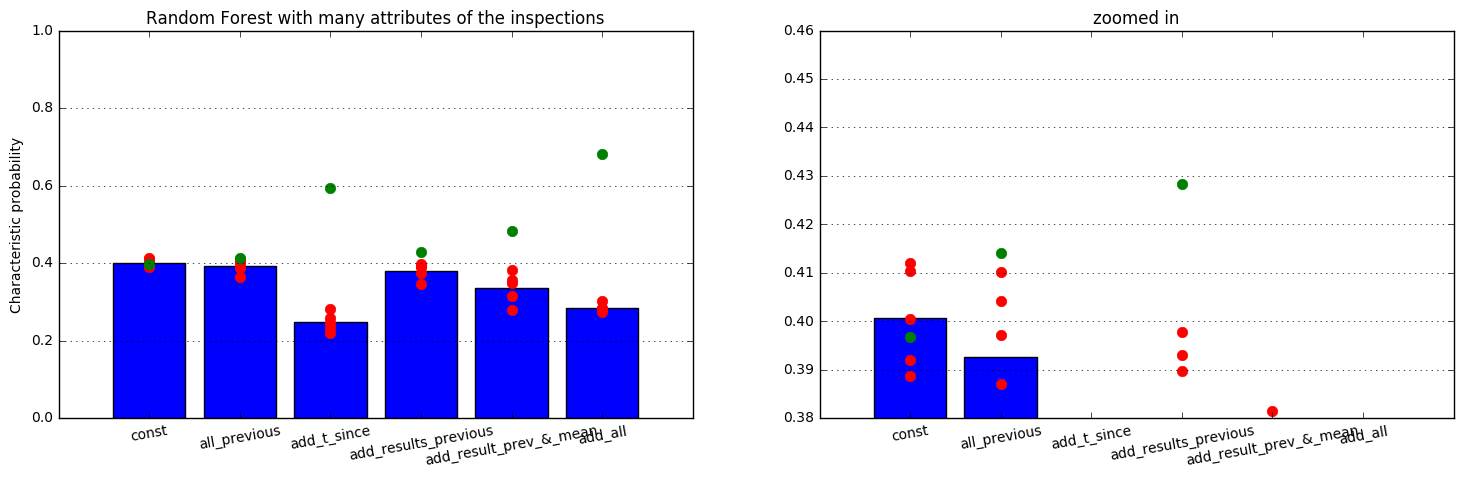

In [53]:
# Make Random Forest models with 5-fold CV and plotting.

n = Y.shape[0]
n_folds = 5
kf = TimeSeriesSplit(n_splits=n_folds)

model_names = ['const','all_previous','add_t_since','add_results_previous','add_result_prev_&_mean','add_all']
n_models = len(model_names)

# Define the predictors for each model
X1 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx]),axis=1).values
X0 = (X1[:,0]*0+1).reshape(-1,1)
X2 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.days_since_insp),axis=1).values
X3 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2),axis=1).values
X4 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result),axis=1).values
X5 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result,insp_final.days_since_insp),axis=1).values

# Aggregate the predictors for all the models
allX = []
for i in range(n_models):
    allX.append(eval('X{}'.format(i)))

# Loop through the k-folds
mll = np.empty((n_folds,n_models))
charp = np.empty_like(mll)
for i,(ktrain,ktest) in enumerate(kf.split(Y)):
    
    for j in range(n_models):
        mdl = RFC().fit(allX[j][ktrain,:],Y[ktrain])
        Yproba = mdl.predict_proba(allX[j][ktest,:])
        mll[i,j],charp[i,j] = log_loss(Y[ktest],Yproba)
        
# Also fit the entire data to get in-sample fits
mll_insample = np.empty(n_models)
charp_insample = np.empty_like(mll_insample)
for j in range(n_models):
    mdl = RFC().fit(allX[j],Y)
    Yproba = mdl.predict_proba(allX[j])
    mll_insample[j],charp_insample[j] = log_loss(Y,Yproba)
    
# Plot the characteristic probability for each of the models
plt.figure(figsize=(18,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    mnp = charp.mean(axis=0)
    plt.bar(np.arange(n_models),mnp,align="center")
    mgx,_ = np.meshgrid(range(n_models),range(n_folds))
    plt.plot(mgx,charp,'r.',markersize=15)
    plt.plot(mgx[0,:],charp_insample,'g.',markersize=15)
    plt.xticks(mgx[0,:],model_names,rotation=10)
    plt.ylim([0,1])
    plt.grid(axis='y')
    plt.title('Random Forest with many attributes of the inspections')
    if i==1:
        plt.ylim([0.38,0.46])
        plt.title('zoomed in')
    else:
        plt.ylabel('Characteristic probability')
plt.show()

Looks real bad without tuning, gotta tighten that up!

In [63]:
# Make Random Forest models with 5-fold CV and tune it

n = Y.shape[0]
n_folds = 5
kf = TimeSeriesSplit(n_splits=n_folds)

model_names = ['all_preds']
n_models = len(model_names)

# Define the predictors for each model
X0 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result,insp_final.days_since_insp),axis=1).values

# Aggregate the predictors for all the models
allX = []
for i in range(n_models):
    allX.append(eval('X{}'.format(i)))

# Parameters for tuning a random forest model
n_trees = np.arange(10, 100, 20)  # Trees and depth are explored on an exponentially growing space,
depths = np.arange(2, 15)   # since it is assumed that trees and depth will add accuracy in a decaying fashion.

# To keep track of the best model
best_score = 0

# Run grid search for model with 5-fold cross validation
print '5-fold cross validation:'

mll = np.empty((n_folds))
charp = np.empty_like(mll)
for i,(ktrain,ktest) in enumerate(kf.split(Y)):
    mdl = RFC(n_estimators=trees, max_depth=depth).fit(allX[0][ktrain,:],Y[ktrain])
    Yproba = mdl.predict_proba(allX[0][ktest,:])
    mll[i],charp[i] = log_loss(Y[ktest],Yproba)
# Record and report probability
average_p = np.mean(charp)

for trees in n_trees:
    for depth in depths:
        mll = np.empty((n_folds))
        charp = np.empty_like(mll)
        for i,(ktrain,ktest) in enumerate(kf.split(Y)):
            mdl = RFC(n_estimators=trees, max_depth=depth).fit(allX[0][ktrain,:],Y[ktrain])
            Yproba = mdl.predict_proba(allX[0][ktest,:])
            mll[i],charp[i] = log_loss(Y[ktest],Yproba)
        # Record and report probability
        average_p = np.mean(charp)
                   
        # Record and report accuracy
        print "Trees:", trees, "Depth:", depth, "Probability:", average_p
        
        # Update our record of the best parameters see so far
        if average_p > best_score:
            best_score = average_p
            best_trees = trees
            best_depth = depth

print 'Chosen number of trees, depth:', best_trees, ',', best_depth

5-fold cross validation:
Trees: 10 Depth: 2 Probability: 0.405210168801
Trees: 10 Depth: 3 Probability: 0.407892479638
Trees: 10 Depth: 4 Probability: 0.408859500043
Trees: 10 Depth: 5 Probability: 0.40988050408
Trees: 10 Depth: 6 Probability: 0.41040214248
Trees: 10 Depth: 7 Probability: 0.411207465636
Trees: 10 Depth: 8 Probability: 0.410815495651
Trees: 10 Depth: 9 Probability: 0.410758232017
Trees: 10 Depth: 10 Probability: 0.410701768952
Trees: 10 Depth: 11 Probability: 0.41033885775
Trees: 10 Depth: 12 Probability: 0.409719614037
Trees: 10 Depth: 13 Probability: 0.409307366886
Trees: 10 Depth: 14 Probability: 0.407635116869
Trees: 30 Depth: 2 Probability: 0.405896492367
Trees: 30 Depth: 3 Probability: 0.407742857071
Trees: 30 Depth: 4 Probability: 0.409191267721
Trees: 30 Depth: 5 Probability: 0.409953493233
Trees: 30 Depth: 6 Probability: 0.411037101594
Trees: 30 Depth: 7 Probability: 0.411489074982
Trees: 30 Depth: 8 Probability: 0.411619209552
Trees: 30 Depth: 9 Probability: 0

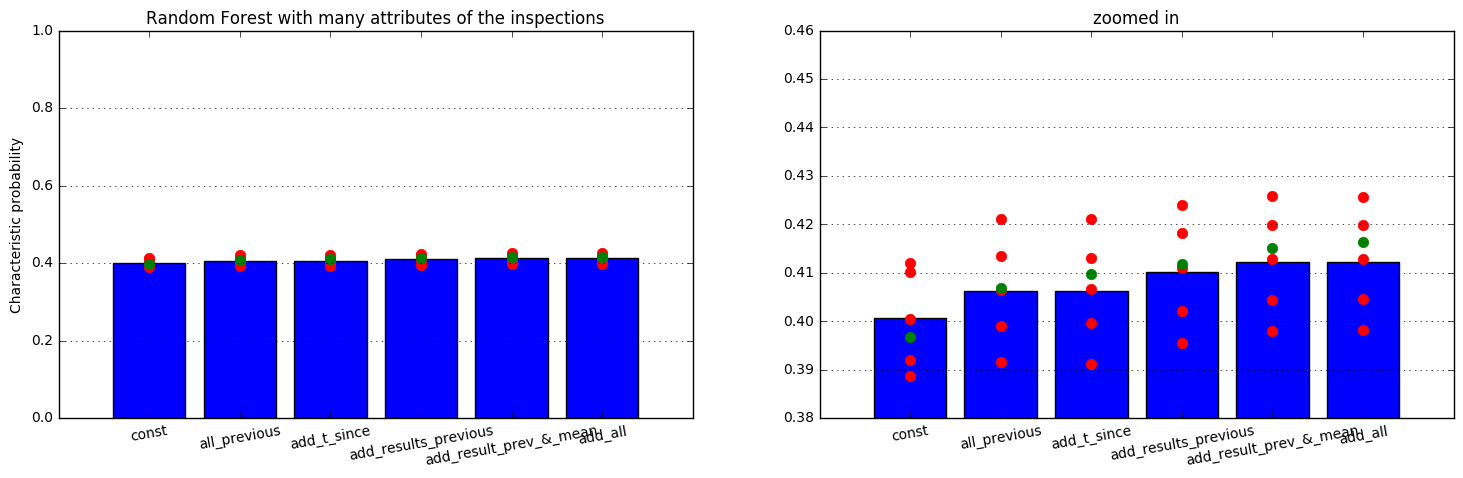

In [64]:
# Make Random Forest models with 5-fold CV and plotting (TUNED)

n = Y.shape[0]
n_folds = 5
kf = TimeSeriesSplit(n_splits=n_folds)

model_names = ['const','all_previous','add_t_since','add_results_previous','add_result_prev_&_mean','add_all']
n_models = len(model_names)

# Define the predictors for each model
X1 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx]),axis=1).values
X0 = (X1[:,0]*0+1).reshape(-1,1)
X2 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.days_since_insp),axis=1).values
X3 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2),axis=1).values
X4 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result),axis=1).values
X5 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result,insp_final.days_since_insp),axis=1).values

# Aggregate the predictors for all the models
allX = []
for i in range(n_models):
    allX.append(eval('X{}'.format(i)))

# Loop through the k-folds
mll = np.empty((n_folds,n_models))
charp = np.empty_like(mll)
for i,(ktrain,ktest) in enumerate(kf.split(Y)):
    
    for j in range(n_models):
        mdl = RFC(n_estimators=90, max_depth=9).fit(allX[j][ktrain,:],Y[ktrain])
        Yproba = mdl.predict_proba(allX[j][ktest,:])
        mll[i,j],charp[i,j] = log_loss(Y[ktest],Yproba)
        
# Also fit the entire data to get in-sample fits
mll_insample = np.empty(n_models)
charp_insample = np.empty_like(mll_insample)
for j in range(n_models):
    mdl = RFC(n_estimators=90, max_depth=9).fit(allX[j],Y)
    Yproba = mdl.predict_proba(allX[j])
    mll_insample[j],charp_insample[j] = log_loss(Y,Yproba)
    
# Plot the characteristic probability for each of the models
plt.figure(figsize=(18,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    mnp = charp.mean(axis=0)
    plt.bar(np.arange(n_models),mnp,align="center")
    mgx,_ = np.meshgrid(range(n_models),range(n_folds))
    plt.plot(mgx,charp,'r.',markersize=15)
    plt.plot(mgx[0,:],charp_insample,'g.',markersize=15)
    plt.xticks(mgx[0,:],model_names,rotation=10)
    plt.ylim([0,1])
    plt.grid(axis='y')
    plt.title('Random Forest with many attributes of the inspections')
    if i==1:
        plt.ylim([0.38,0.46])
        plt.title('zoomed in')
    else:
        plt.ylabel('Characteristic probability')
plt.show()

In [ ]:
#runmodel: a function to run our 5-fold CV model with in-sample fits
def runmodel()
# Loop through the k-folds
mll = np.empty((n_folds,n_models))
charp = np.empty_like(mll)
for i,(ktrain,ktest) in enumerate(kf.split(Y)):
    
    for j in range(n_models):
        mdl = RFC(n_estimators=90, max_depth=9).fit(allX[j][ktrain,:],Y[ktrain])
        Yproba = mdl.predict_proba(allX[j][ktest,:])
        mll[i,j],charp[i,j] = log_loss(Y[ktest],Yproba)
        
# Also fit the entire data to get in-sample fits
mll_insample = np.empty(n_models)
charp_insample = np.empty_like(mll_insample)
for j in range(n_models):
    mdl = RFC(n_estimators=90, max_depth=9).fit(allX[j],Y)
    Yproba = mdl.predict_proba(allX[j])
    mll_insample[j],charp_insample[j] = log_loss(Y,Yproba)

In [74]:
models = [LogReg(C=1000),KNN(n_neighbors = 75),RFC(n_estimators=90, max_depth=9)]
models[2]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=90, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [84]:
# Make AdaBoost models with 5-fold CV and tune it

n = Y.shape[0]
n_folds = 5
kf = TimeSeriesSplit(n_splits=n_folds)

model_names = ['all_preds']
n_models = len(model_names)

# Define the predictors for each model
X0 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result,insp_final.days_since_insp),axis=1).values

# Parameters for tuning a random forest model
n_trees = np.arange(10, 100, 20)
rates = np.arange(2, 15)

# To keep track of the best model
best_score = 0

# Run grid search for model with 5-fold cross validation
print '5-fold cross validation:'

for trees in n_trees:
    for rate in rates:
        mll = np.empty((n_folds))
        charp = np.empty_like(mll)
        for i,(ktrain,ktest) in enumerate(kf.split(Y)):
            mdl = AdaBoost(n_estimators=trees, learning_rate=rate).fit(X0[ktrain,:],Y[ktrain])
            Yproba = mdl.predict_proba(X0[ktest,:])
            mll[i],charp[i] = log_loss(Y[ktest],Yproba)
        # Record and report probability
        average_p = np.mean(charp)
                   
        # Record and report accuracy
        print "Trees:", trees, "Rate:", rate, "Probability:", average_p
        
        # Update our record of the best parameters see so far
        if average_p > best_score:
            best_score = average_p
            best_trees = trees
            best_rate = rate

print 'Chosen number of trees, depth:', best_trees, ',', best_depth

5-fold cross validation:
Trees: 10 Rate: 2 Probability: 0.334296262957
Trees: 10 Rate: 3 Probability: 0.249173843987
Trees: 10 Rate: 4 Probability: 0.218910713699
Trees: 10 Rate: 5 Probability: 0.164073808363
Trees: 10 Rate: 6 Probability: 0.229578632551
Trees: 10 Rate: 7 Probability: 0.207241293103
Trees: 10 Rate: 8 Probability: 0.301406874928
Trees: 10 Rate: 9 Probability: 0.279584930037
Trees: 10 Rate: 10 Probability: 0.255102195896
Trees: 10 Rate: 11 Probability: 0.244136658652
Trees: 10 Rate: 12 Probability: 0.235755992464
Trees: 10 Rate: 13 Probability: 0.227372516551
Trees: 10 Rate: 14 Probability: 0.230280403996
Trees: 30 Rate: 2 Probability: 0.333697833382
Trees: 30 Rate: 3 Probability: 0.315432602388
Trees: 30 Rate: 4 Probability: 0.3157333384
Trees: 30 Rate: 5 Probability: 0.336195699853
Trees: 30 Rate: 6 Probability: 0.390171766526
Trees: 30 Rate: 7 Probability: 0.355374017601
Trees: 30 Rate: 8 Probability: 0.372391153578
Trees: 30 Rate: 9 Probability: 0.381653954981
Trees:

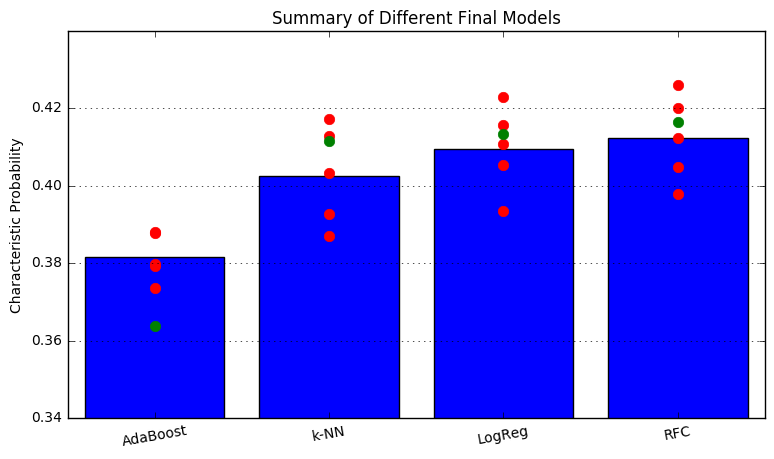

In [88]:
# Compare the best models we've got

n = Y.shape[0]
n_folds = 5
kf = TimeSeriesSplit(n_splits=n_folds)

model_names = ['AdaBoost', 'k-NN','LogReg', 'RFC']
models = [AdaBoost(n_estimators=30, learning_rate=9), KNN(n_neighbors = 75), LogReg(C=1000), RFC(n_estimators=90, max_depth=9)]
n_models = len(model_names)

# Define the predictors for each model
X0= pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result,insp_final.days_since_insp),axis=1).values

# Loop through the k-folds
mll = np.empty((n_folds,n_models))
charp = np.empty_like(mll)
for i,(ktrain,ktest) in enumerate(kf.split(Y)):  
    for j in range(n_models):
        model = models[j]
        mdl = model.fit(X0[ktrain,:],Y[ktrain])
        Yproba = mdl.predict_proba(X0[ktest,:])
        mll[i,j],charp[i,j] = log_loss(Y[ktest],Yproba)
        
# Also fit the entire data to get in-sample fits
mll_insample = np.empty(n_models)
charp_insample = np.empty_like(mll_insample)
for j in range(n_models):
    mdl = models[j].fit(X0,Y)
    Yproba = mdl.predict_proba(X0)
    mll_insample[j],charp_insample[j] = log_loss(Y,Yproba)
    
# Plot the characteristic probability for all the models
plt.figure(figsize=(9,5))
mnp = charp.mean(axis=0)
plt.bar(np.arange(n_models),mnp,align="center")
mgx,_ = np.meshgrid(range(n_models),range(n_folds))
plt.plot(mgx,charp,'r.',markersize=15)
plt.plot(mgx[0,:],charp_insample,'g.',markersize=15)
plt.xticks(mgx[0,:],model_names,rotation=10)
plt.grid(axis='y')
plt.title('Summary of Different Final Models')
plt.ylim([0.34,0.44])
plt.ylabel('Characteristic Probability')
plt.show()

In [90]:
insp_final.to_csv('insp_final.csv', sep=',')

Compare Performance of LogReg to RFC:

In [92]:
# Train on data up to (including) 2015

# arrange training and testing data
X = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result,insp_final.days_since_insp),axis=1).values
X0 = (X[:,0]*0+1).reshape(-1,1)
ktrain = (insp_final.date<pd.datetime(2016,1,1)).values
ktest = []
ktest.append(None)
for i in range(1,11):
    temp = ((insp_final.date>=pd.datetime(2016,i,1)) & (insp_final.date<pd.datetime(2016,i+1,1))).values
    ktest.append(temp)

# train the model
mdl0 = LogReg(C=1000).fit(X0[ktrain,:],Y[ktrain])
mdl1 = LogReg(C=1000).fit(X[ktrain,:],Y[ktrain])
mdl2 = RFC(n_estimators=90, max_depth=9).fit(X[ktrain,:],Y[ktrain])

In [104]:
# For each month, order the inspections by risk according to all models.

comp_caught = np.empty((11,5))

for i in range(1,11):
    # Calculate model probabilities
    Yproba1 = mdl1.predict_proba(X[ktest[i],:])
    df_test_month1 = pd.DataFrame(insp_final.iloc[ktest[i],:])
    df_test_month1['mdl1_score']=Yproba1[:,2]
    Yproba2 = mdl2.predict_proba(X[ktest[i],:])
    df_test_month2 = pd.DataFrame(insp_final.iloc[ktest[i],:])
    df_test_month2['mdl2_score']=Yproba2[:,2]
    
    # Sort the df by different quantities
    stat_quo = df_test_month.sort_values('date')
    bl_mdl = df_test_month.sample(frac=1)
    mdl1_based = df_test_month1.sort_values('mdl1_score',ascending=False)
    mdl2_based = df_test_month2.sort_values('mdl2_score',ascending=False)

    # Check how many critical violations are caught in the first half
    n_half = len(df_test_month)//2
    comp_caught[i,0] = (stat_quo.iloc[:n_half,:].Results==2).sum()
    comp_caught[i,1] = (bl_mdl.iloc[:n_half,:].Results==2).sum()
    comp_caught[i,2] = (mdl1_based.iloc[:n_half,:].Results==2).sum()
    comp_caught[i,3] = (mdl2_based.iloc[:n_half,:].Results==2).sum()
    comp_caught[i,4] = (df_test_month.Results==2).sum()
    

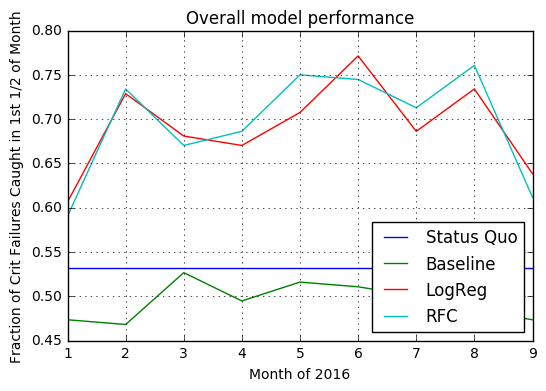

In [105]:
comp_caught[1:,:-1]
v = comp_caught[1:,:-1]/comp_caught[1:,-1].reshape(-1,1)

plt.plot(range(1,10),v[:-1,:])
plt.xlabel('Month of 2016')
plt.ylabel('Fraction of Crit Failures Caught in 1st 1/2 of Month')
plt.legend(('Status Quo','Baseline','LogReg', 'RFC'),loc='lower right')
plt.grid('on')
plt.title('Overall model performance')

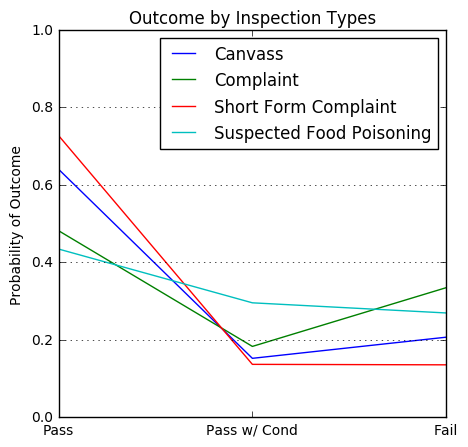

In [54]:
# Plot the inpection outcomes by type

v = insp_final.groupby('inspection_type').Results.value_counts(normalize=True).unstack().fillna(0)

vt = v.ix[:7,:]
plt.figure(figsize=(5,5))
plt.plot(vt.values.T)
plt.legend(vt.index, loc=1)
plt.xlim([0,2])
plt.ylim([0,1])
plt.title('Outcome by Inspection Types')
plt.ylabel('Probability of Outcome')
plt.xticks(range(3),('Pass','Pass w/ Cond','Fail'))
plt.grid(axis='y')
plt.show()

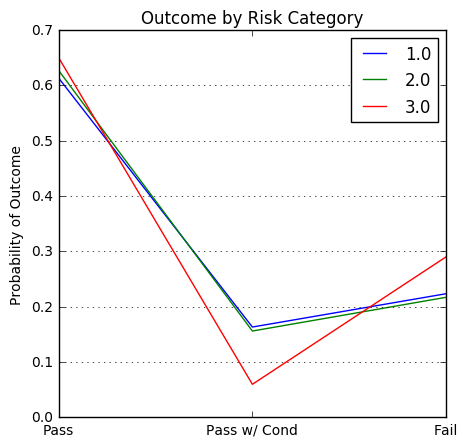

In [55]:
v = insp_final.groupby('Risk').Results.value_counts(normalize=True).unstack()
plt.figure(figsize=(5,5))
plt.plot(v.T)
plt.legend(v.index)
plt.title('Outcome by Risk Category')
plt.ylabel('Probability of Outcome')
plt.xticks(range(3),('Pass','Pass w/ Cond','Fail'))
plt.grid(axis='y')
plt.show()

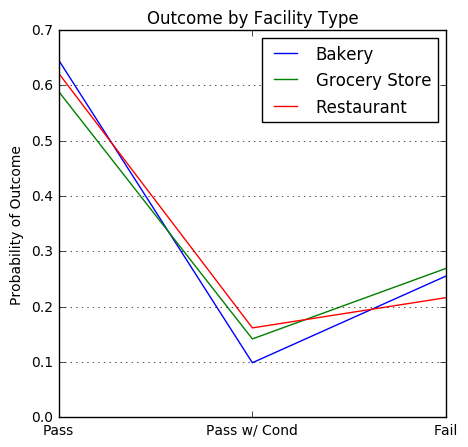

In [56]:
v = insp_final.groupby('facility').Results.value_counts(normalize=True).unstack()
plt.figure(figsize=(5,5))
plt.plot(v.T)
plt.legend(v.index)
plt.title('Outcome by Facility Type')
plt.ylabel('Probability of Outcome')
plt.xticks(range(3),('Pass','Pass w/ Cond','Fail'))
plt.grid(axis='y')
plt.show()